# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


In [1]:
import os

In [2]:
#check contents of data folder 
os.listdir("../data")

['train.p', 'valid.p', 'test.p', '.ipynb_checkpoints']

---
## Step 0: Load The Data

In [3]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = '../data/train.p'
validation_file='../data/valid.p'
testing_file = '../data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results
import numpy as np


# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of validation examples
n_validation = X_valid.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).shape[0]

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s).

- First we can visualize some images sampled from training set:

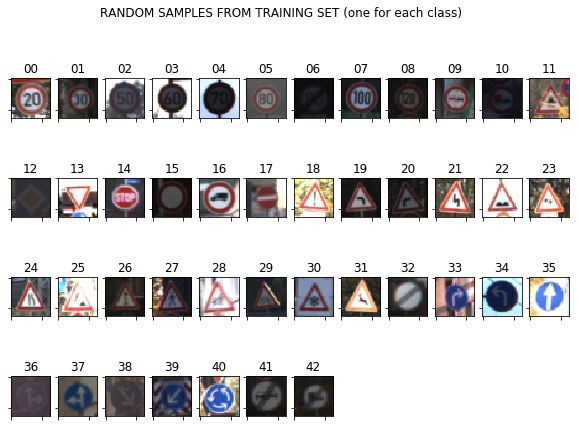

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
%matplotlib inline

# show a random sample from each class of the traffic sign dataset
rows, cols = 4, 12
fig, ax_array = plt.subplots(rows, cols, figsize=(10,7))
plt.suptitle('RANDOM SAMPLES FROM TRAINING SET (one for each class)')
for class_idx, ax in enumerate(ax_array.ravel()):
    if class_idx < n_classes:
        # show a random image of the current class
        cur_X = X_train[y_train == class_idx]
        cur_img = cur_X[np.random.randint(len(cur_X))]
        ax.imshow(cur_img)
        ax.set_title('{:02d}'.format(class_idx))
    else:
        ax.axis('off')
# hide both x and y ticks
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.draw()

- We can also get the idea of how these classes are distributed in both training and testing set

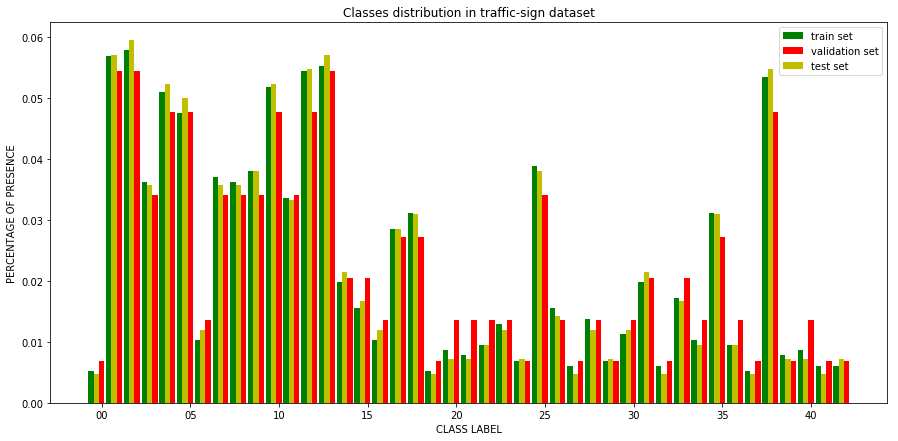

In [6]:
# bar-chart of classes distribution
train_distribution, test_distribution, validation_distribution = np.zeros(n_classes), np.zeros(n_classes), np.zeros(n_classes)
for c in range(n_classes):
    train_distribution[c] = np.sum(y_train == c) / n_train
    test_distribution[c] = np.sum(y_test == c) / n_test
    validation_distribution[c] = np.sum(y_valid == c) / n_validation
fig, ax = plt.subplots(figsize=(15,7))
col_width = 0.3
bar_train = ax.bar(np.arange(n_classes)-col_width, train_distribution, width=col_width, color='g',align='center')
bar_test = ax.bar(np.arange(n_classes), test_distribution, width=col_width, color='y',align='center')
bar_validation = ax.bar(np.arange(n_classes)+col_width, validation_distribution, width=col_width, color='r',align='center')
ax.set_ylabel('PERCENTAGE OF PRESENCE')
ax.set_xlabel('CLASS LABEL')
ax.set_title('Classes distribution in traffic-sign dataset')
ax.set_xticks(np.arange(0, n_classes, 5)+col_width)
ax.set_xticklabels(['{:02d}'.format(c) for c in range(0, n_classes, 5)])
ax.legend((bar_train[0],bar_validation[0], bar_test[0]), ('train set', 'validation set', 'test set'))
plt.show()

From this plot we notice that there's a strong *imbalance among the classes*. Indeed, some classes are relatively over-represented, while some others are much less common. However, we see that the data distribution is almost the same between training, validation and testing set, and this is good news: looks like we won't have problem related to *dataset shift* when we'll evaluate our model on the test data.

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.


### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

**Feature preprocessing**

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

import cv2 

def preprocess_features(X, equalize_hist=True):

    # convert from RGB to YUV
    X = np.array([np.expand_dims(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2YUV)[:, :, 0], 2) for rgb_img in X])

    # adjust image contrast
    if equalize_hist:
        X = np.array([np.expand_dims(cv2.equalizeHist(np.uint8(img)), 2) for img in X])

    X = np.float32(X)

    # standardize features
    X -= np.mean(X, axis=0)
    X /= (np.std(X, axis=0) + np.finfo('float32').eps)

    return X

X_train_norm = preprocess_features(X_train)
X_valid_norm = preprocess_features(X_valid)
X_test_norm = preprocess_features(X_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_


**Answer:**
Following this paper [[Sermanet, LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) I employed three main steps of feature preprocessing:

1) *Each image is converted from RGB to YUV color space, then only the Y channel is used.* This choice can sound at first suprising, but the cited paper shows how this choice leads to the best performing model. This is slightly counter-intuitive, but if we think about it arguably we are able to distinguish all the traffic signs just by looking to the grayscale image.

2) *Contrast of each image is adjusted by means of histogram equalization*. This is to mitigate the numerous situation in which the image contrast is really poor.

3) *Each image is centered on zero mean and divided for its standard deviation*. This feature scaling is known to have beneficial effects on the gradient descent performed by the optimizer.

### Data Augmentation

Using TensorFlow backend.


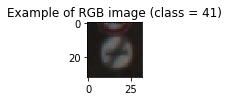

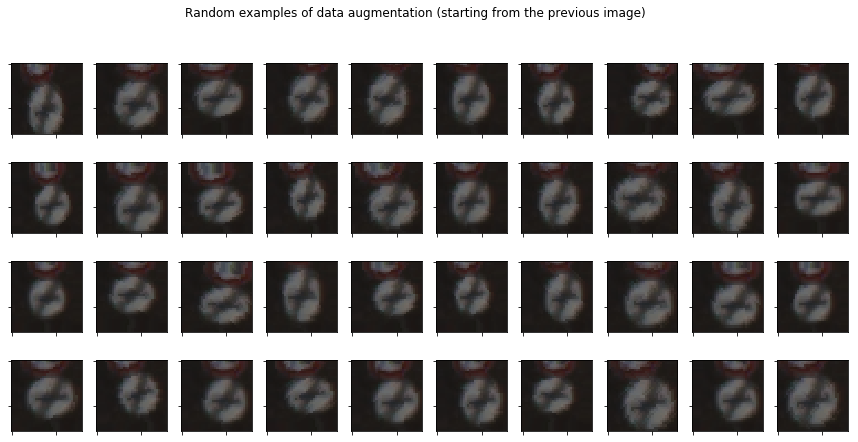

In [8]:
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator

# create the generator to perform online data augmentation
image_datagen = ImageDataGenerator(rotation_range=15.,
                                   zoom_range=0.2,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1)

# take a random image from the training set
img_rgb = X_train[0]

# plot the original image
plt.figure(figsize=(1,1))
plt.imshow(img_rgb)
plt.title('Example of RGB image (class = {})'.format(y_train[0]))
plt.show()

# plot some randomly augmented images
rows, cols = 4, 10
fig, ax_array = plt.subplots(rows, cols, figsize=(15,7))
for ax in ax_array.ravel():
    augmented_img, _ = image_datagen.flow(np.expand_dims(img_rgb, 0), y_train[0:1]).next()
    ax.imshow(np.uint8(np.squeeze(augmented_img)))
plt.setp([a.get_xticklabels() for a in ax_array.ravel()], visible=False)
plt.setp([a.get_yticklabels() for a in ax_array.ravel()], visible=False)
plt.suptitle('Random examples of data augmentation (starting from the previous image)')
plt.show()

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_
    
**Answer:** For the *train, validation and test split*, I just used the ones provided, composed by 34799, 4410 and 12630 examples respectively.


To get *additional data*, I leveraged on the `ImageDataGenerator` class provided in the [Keras](https://keras.io/preprocessing/image/) library. No need to re-invent the wheel! In this way I could perform data augmentation online, during the training. Training images are randomly rotated, zoomed and shifted but just in a narrow range, in order to create some variety in the data while not completely twisting the original feature content. The result of this process of augmentation is visible in the previous figure.

### Model Architecture

In [9]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

import tensorflow as tf

from tensorflow.contrib.layers import flatten


def weight_variable(shape, mu=0, sigma=0.1):
    initialization = tf.truncated_normal(shape=shape, mean=mu, stddev=sigma)
    return tf.Variable(initialization)


def bias_variable(shape, start_val=0.1):
    initialization = tf.constant(start_val, shape=shape)
    return tf.Variable(initialization)


def conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME'):
    return tf.nn.conv2d(input=x, filter=W, strides=strides, padding=padding)


def max_pool_2x2(x):
    return tf.nn.max_pool(value=x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')


# network architecture definition
def my_net(x, n_classes):

    c1_out = 64
    conv1_W = weight_variable(shape=(3, 3, 1, c1_out))
    conv1_b = bias_variable(shape=(c1_out,))
    conv1 = tf.nn.relu(conv2d(x, conv1_W) + conv1_b)

    pool1 = max_pool_2x2(conv1)

    drop1 = tf.nn.dropout(pool1, keep_prob=keep_prob1)

    c2_out = 128
    conv2_W = weight_variable(shape=(3, 3, c1_out, c2_out))
    conv2_b = bias_variable(shape=(c2_out,))
    conv2 = tf.nn.relu(conv2d(drop1, conv2_W) + conv2_b)

    pool2 = max_pool_2x2(conv2)

    drop2 = tf.nn.dropout(pool2, keep_prob=keep_prob2)

    fc0 = tf.concat([flatten(drop1), flatten(drop2)],axis=1)

    fc1_out = 64
    fc1_W = weight_variable(shape=(fc0._shape[1].value, fc1_out))
    fc1_b = bias_variable(shape=(fc1_out,))
    fc1 = tf.matmul(fc0, fc1_W) + fc1_b

    drop_fc1 = tf.nn.dropout(fc1, keep_prob=keep_prob3)

    fc2_out = n_classes
    fc2_W = weight_variable(shape=(drop_fc1._shape[1].value, fc2_out))
    fc2_b = bias_variable(shape=(fc2_out,))
    logits = tf.matmul(drop_fc1, fc2_W) + fc2_b

    return logits


# placeholders
x = tf.placeholder(dtype=tf.float32, shape=(None, 32, 32, 1))
y = tf.placeholder(dtype=tf.int32, shape=None)
keep_prob1 = tf.placeholder(tf.float32)
keep_prob2 = tf.placeholder(tf.float32)
keep_prob3 = tf.placeholder(tf.float32)


# training pipeline
lr = 0.001
logits = my_net(x, n_classes=n_classes)
cross_entropy = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y)
loss_function = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=lr)
train_step = optimizer.minimize(loss=loss_function)

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)_

**Answer:** The final architecture is a relatively shallow network made by 4 layers. The first two layers are convolutional, while the third and last are fully connected. Following [[Sermanet, LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) the output of both the first and second convolutional layers are concatenated and fed to the following dense layer. In this way we provide the fully-connected layer visual patterns at both different levels of abstraction. The last fully-connected layer then maps the prediction into one of the 43 classes.

In [10]:
# metrics and functions for model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.cast(y, tf.int64))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

def evaluate(X_data, y_data):
    
    num_examples = X_data.shape[0]
    total_accuracy = 0
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCHSIZE):
        batch_x, batch_y = X_data[offset:offset+BATCHSIZE], y_data[offset:offset+BATCHSIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob1: 1.0,keep_prob2 : 1.0,keep_prob3 : 1.0})
        total_accuracy += accuracy * len(batch_x)
        
    return total_accuracy / num_examples

# create a checkpointer to log the weights during training
checkpointer = tf.train.Saver()

In [11]:
# training hyperparameters
BATCHSIZE = 128
EPOCHS = 30
BATCHES_PER_EPOCH = 5000

### Train, Validate and Test the Model

In [19]:
# start training
with tf.Session() as sess:

    sess.run(tf.global_variables_initializer())

    for epoch in range(EPOCHS):

        print("EPOCH {} ...".format(epoch + 1))

        batch_counter = 0
        for batch_x, batch_y in image_datagen.flow(X_train_norm, y_train, batch_size=BATCHSIZE):

            batch_counter += 1
            sess.run(train_step, feed_dict={x: batch_x, y: batch_y, keep_prob1: 0.5,keep_prob2 : 0.6,keep_prob3 : 0.6})

            if batch_counter == BATCHES_PER_EPOCH:
                break

        # at epoch end, evaluate accuracy on both training and validation set
        train_accuracy = evaluate(X_train_norm, y_train)
        val_accuracy = evaluate(X_valid_norm, y_valid)
        print('Train Accuracy = {:.3f} - Validation Accuracy: {:.3f}'.format(train_accuracy, val_accuracy))
        
        # log current weights
        #helps to load model with last best set of weights
        checkpointer.save(sess, save_path='../checkpoints/traffic_sign_model.ckpt', global_step=epoch)

EPOCH 1 ...
Train Accuracy = 0.947 - Validation Accuracy: 0.876
EPOCH 2 ...
Train Accuracy = 0.982 - Validation Accuracy: 0.918
EPOCH 3 ...
Train Accuracy = 0.991 - Validation Accuracy: 0.925
EPOCH 4 ...
Train Accuracy = 0.995 - Validation Accuracy: 0.949
EPOCH 5 ...
Train Accuracy = 0.996 - Validation Accuracy: 0.940
EPOCH 6 ...
Train Accuracy = 0.996 - Validation Accuracy: 0.945
EPOCH 7 ...
Train Accuracy = 0.996 - Validation Accuracy: 0.954
EPOCH 8 ...
Train Accuracy = 0.998 - Validation Accuracy: 0.956
EPOCH 9 ...
Train Accuracy = 0.997 - Validation Accuracy: 0.953
EPOCH 10 ...
Train Accuracy = 0.999 - Validation Accuracy: 0.956
EPOCH 11 ...
Train Accuracy = 0.999 - Validation Accuracy: 0.958
EPOCH 12 ...
Train Accuracy = 0.998 - Validation Accuracy: 0.961
EPOCH 13 ...
Train Accuracy = 0.998 - Validation Accuracy: 0.957
EPOCH 14 ...
Train Accuracy = 0.997 - Validation Accuracy: 0.952
EPOCH 15 ...
Train Accuracy = 0.999 - Validation Accuracy: 0.955
EPOCH 16 ...
Train Accuracy = 0.99

In [53]:
os.listdir("../checkpoints")

['checkpoint',
 'traffic_sign_model.ckpt-27.index',
 'traffic_sign_model.ckpt-29.meta',
 'traffic_sign_model.ckpt-29.data-00000-of-00001',
 'traffic_sign_model.ckpt-25.data-00000-of-00001',
 'traffic_sign_model.ckpt-26.data-00000-of-00001',
 'traffic_sign_model.ckpt-28.data-00000-of-00001',
 'traffic_sign_model.ckpt-25.meta',
 'traffic_sign_model.ckpt-27.meta',
 'traffic_sign_model.ckpt-26.meta',
 'traffic_sign_model.ckpt-26.index',
 'traffic_sign_model.ckpt-27.data-00000-of-00001',
 'traffic_sign_model.ckpt-28.meta',
 'traffic_sign_model.ckpt-29.index',
 'traffic_sign_model.ckpt-28.index',
 'traffic_sign_model.ckpt-25.index']

In [12]:
# testing the model
import tens
with tf.Session() as sess:

    # I don't know why checkpoints before 25 were not saved, so using other saved session
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-28')
    
    test_accuracy = evaluate(X_test_norm, y_test)
    print('Performance on test set: {:.3f}'.format(test_accuracy))


INFO:tensorflow:Restoring parameters from ../checkpoints/traffic_sign_model.ckpt-28
Performance on test set: 0.953


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** For the trainig I used *Adam optimizer*, which often proves to be a good choice to avoid the patient search of the right parameters for SGD. *Batchsize* was set to 128 due to memory constraint. Every 5000 batches visited, an evaluation on both training and validation set is performed. In order to avoid overfitting, both data augmentation and dropout (with different drop probability in different layers) are employed extensively.
    
    
### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** The network architecture is based on the paper [[Sermanet, LeCun]](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf), in which the authors tackle the same problem (traffic sign classification), though using a different dataset. In section *II-A* of the paper, the authors explain that they found beneficial to feed the dense layers with the output of both the previous convolutional layers. Indeed, in this way the classifier is explicitly provided both the local "motifs" (learned by conv1) and the more "global" shapes and structure (learned by conv2) found in the features. I tried to replicate the same architecture, made by 2 convolutional and 2 fully connected layers. 

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

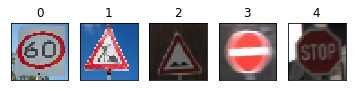

In [13]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

### Load the images and plot them here.
import os

# load new images
new_images_dir = '../new_signs'
new_test_images = [os.path.join(new_images_dir, f) for f in os.listdir(new_images_dir) if f.endswith(".jpg") ]
new_test_images = [cv2.resize(cv2.imread(f), (32, 32)) for f in new_test_images]
new_test_images = [cv2.cvtColor(f, cv2.COLOR_BGR2RGB) for f in new_test_images]

# manually annotated labels for these new images
new_targets = [3, 25, 22, 17, 14]

# plot new test images
fig, axarray = plt.subplots(1, len(new_test_images))
for i, ax in enumerate(axarray.ravel()):
    ax.imshow(new_test_images[i])
    ax.set_title('{}'.format(i))
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_xticks([]), ax.set_yticks([])

### Predict the Sign Type for Each Image

In [15]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

# first things first: feature preprocessing
new_test_images_norm = preprocess_features(new_test_images)

with tf.Session() as sess:

    # restore saved session
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-28')

    # predict on unseen images
    prediction = np.argmax(np.array(sess.run(logits, feed_dict={x: new_test_images_norm, keep_prob1: 1.0,keep_prob2 : 1.0,keep_prob3 : 1.0})), axis=1)

for i, pred in enumerate(prediction):
    print('Image {} - Target = {:02d}, Predicted = {:02d}'.format(i, new_targets[i], pred))
    
print('> Model accuracy: {:.02f}'.format(np.sum(new_targets==prediction)/len(new_targets)))

INFO:tensorflow:Restoring parameters from ../checkpoints/traffic_sign_model.ckpt-28
Image 0 - Target = 03, Predicted = 03
Image 1 - Target = 25, Predicted = 25
Image 2 - Target = 22, Predicted = 22
Image 3 - Target = 17, Predicted = 14
Image 4 - Target = 14, Predicted = 14
> Model accuracy: 0.80


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._


**Answer:** All the previous 5 images are taken from web, some of them have bad lighting and are hazy.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

**Answer:** Evaluated on these 5 newly captured pictures, the model accuracy results 80%. While it's true that the performance drop w.r.t. the test set is high (around 15%), we must keep in mind that 5 images are too few to be of any statistical significance. 

### Analyze Performance

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

INFO:tensorflow:Restoring parameters from ../checkpoints/traffic_sign_model.ckpt-28
Top 3 model predictions for image 0 (Target is 03)
   Prediction = 03 with confidence 0.46
   Prediction = 02 with confidence 0.38
   Prediction = 05 with confidence 0.10
Top 3 model predictions for image 1 (Target is 25)
   Prediction = 25 with confidence 1.00
   Prediction = 28 with confidence 0.00
   Prediction = 30 with confidence 0.00
Top 3 model predictions for image 2 (Target is 22)
   Prediction = 22 with confidence 0.63
   Prediction = 25 with confidence 0.21
   Prediction = 30 with confidence 0.06
Top 3 model predictions for image 3 (Target is 17)
   Prediction = 14 with confidence 1.00
   Prediction = 40 with confidence 0.00
   Prediction = 17 with confidence 0.00
Top 3 model predictions for image 4 (Target is 14)
   Prediction = 14 with confidence 0.99
   Prediction = 02 with confidence 0.00
   Prediction = 01 with confidence 0.00


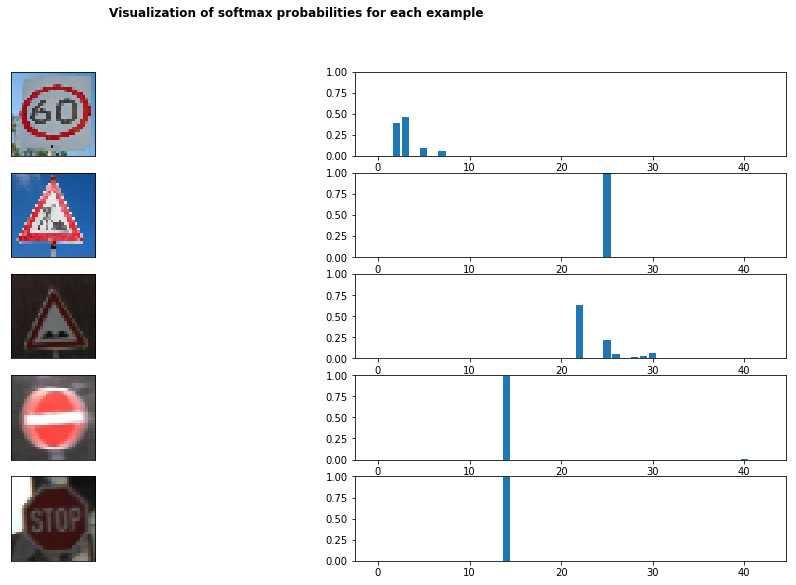

In [18]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

# visualizing softmax probabilities
with tf.Session() as sess:

    # restore saved session
    checkpointer.restore(sess, '../checkpoints/traffic_sign_model.ckpt-28')

    # certainty of predictions
    K = 3
    top_3 = sess.run(tf.nn.top_k(logits, k=K), feed_dict={x: new_test_images_norm, keep_prob1: 1.0,keep_prob2 : 1.0,keep_prob3 : 1.0})

    # compute softmax probabilities
    softmax_probs = sess.run(tf.nn.softmax(logits), feed_dict={x: new_test_images_norm,keep_prob1: 1.0,keep_prob2 : 1.0,keep_prob3 : 1.0})

# plot softmax probs along with traffic sign examples
n_images = new_test_images_norm.shape[0]
fig, axarray = plt.subplots(n_images, 2, figsize = (17,9))
plt.suptitle('Visualization of softmax probabilities for each example', fontweight='bold')
for r in range(0, n_images):
    axarray[r, 0].imshow(np.squeeze(new_test_images[r]))
    axarray[r, 0].set_xticks([]), axarray[r, 0].set_yticks([])
    plt.setp(axarray[r, 0].get_xticklabels(), visible=False)
    plt.setp(axarray[r, 0].get_yticklabels(), visible=False)
    axarray[r, 1].bar(np.arange(n_classes), softmax_probs[r])
    axarray[r, 1].set_ylim([0, 1])
    
# print top K predictions of the model for each example, along with confidence (softmax score)    
for i in range(len(new_test_images)):
    print('Top {} model predictions for image {} (Target is {:02d})'.format(K, i, new_targets[i]))
    for k in range(K):
        top_c = top_3[1][i][k]
        print('   Prediction = {:02d} with confidence {:.2f}'.format(top_c, softmax_probs[i][top_c]))


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

**Answer:** As immediately emerges from the plot above, our model is quite sure of which class the second and fifth traffic signs belong, but it's slightly confused on the first and third. Indeed, in the fourth image the model is not only able to predict the right class, but shows also an high confidence, in this case example (no-entry sign) model's prediction is wrong, nonetheless the correct target appears in the top 3 predictions, which is encouraging.


In the first image of (Speed limit (60km/h)) the model got confused with (Speed limit 50km/h) and (Speed limit 80km/h) signs. In third image the confidence for right class is quite higher than other confused classes.

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")